In [5]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM,GPTQConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import matplotlib.pyplot as plt
import torch
import re
from textblob import TextBlob

In [4]:
!pip install transformers
!pip install optimum
!pip install auto-gptq
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 11.6 MB/s eta 0:00:00a 0:00:01
  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)


In [7]:
df=pd.read_csv('School_Shooting_Data.csv')

In [8]:
df

,Created At,Text,Source,User Name,Location,Description,Followers Count,Quote Count,Reply Count,Retweet Count,Favorite Count
0,Tue Apr 30 23:57:07 +0000 2019,This week: \n• Baltimore: 1 dead\n• Birmingham...,"<a href=""http://twitter.com/download/iphone"" r...",Dante Vic,"Barcelona, Spain",rhythm & blues 🎶 #UNCC17,485,113,112.0,2441.0,4605.0
1,Tue Apr 30 23:29:19 +0000 2019,Two people dead and several injured at the Uni...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Shannon Watts,NaN,"Founder of @MomsDemand, grassroots army of @Ev...",310019,351,507.0,6612.0,16246.0
2,Wed May 01 00:36:25 +0000 2019,Saddened to hear about the news at UNC Charlot...,"<a href=""http://twitter.com/download/iphone"" r...",President Parker 🇺🇸,"Charlotte, NC",Excellence is the Only Standard|#NCCU19 Studen...,7440,0,0.0,44.0,85.0
3,Wed May 01 06:48:12 +0000 2019,It’s a sad reality when there’s been 106 schoo...,"<a href=""http://twitter.com/download/iphone"" r...",Mike Kelleher,"Hazlet, New Jersey",•Part time owner of salernos pizzeria. •GQ Mag...,546,0,0.0,0.0,0.0
4,Wed May 01 02:37:28 +0000 2019,I'm heartsick for the victims of the #UNCC sho...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Elizabeth Warren,Massachusetts,"US Senator, MA. Former teacher & law professor...",2452166,27,123.0,971.0,5327.0
...,...,...,...,...,...,...,...,...,...,...,...
12612,Wed May 01 05:06:02 +0000 2019,My prayers go to the victims and families of t...,"<a href=""http://twitter.com/download/iphone"" r...",Omar Navarro,"Los Angeles, CA",🌟 Republican Running against Maxine Waters 202...,194730,7,33.0,71.0,236.0
12613,Tue Apr 30 23:00:13 +0000 2019,As the news of #uncc breaks... this video make...,"<a href=""http://twitter.com/download/iphone"" r...",BEX {rebekah},"Boston, MA",EP & CoHost of Matty In The Morning on KISS 10...,7877,12,5.0,262.0,518.0
12614,Tue Apr 30 23:25:16 +0000 2019,you didn't have to tell me that the UNCC shoot...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Jeff Tiedrich,NaN,"Don't blame me, I voted for the email lady.",113777,92,199.0,1729.0,7725.0
12615,Wed May 01 02:33:51 +0000 2019,This is my 2¢ #UNCC https://t.co/KhGxf3FXbX,"<a href=""http://twitter.com/download/iphone"" r...",Grant Phillips,"Huntersville, NC",Class of 2019 | Pine Lake Prep Baseball #6 | O...,86,1,0.0,8.0,56.0


In [9]:
# Drop duplicates based on the 'text' column
df.drop_duplicates(subset='Text', keep='first', inplace=True)

In [10]:
df['Text'][100]

'To all of the first responders who came to our rescue today at #UNCC thank you for being so brave, for risking your… https://t.co/HGDOlgtepT'

# Text Cleaning

In [11]:
# Define a function to clean tweets
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove special characters and punctuation
    tweet = re.sub(r'[^A-Za-z0-9]+', ' ', tweet)
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove extra whitespaces
    tweet = ' '.join(tweet.split())
    return tweet

# Apply the cleaning function to the 'Text' column
df['Cleaned_Text'] = df['Text'].apply(clean_tweet)

# Display the cleaned text
print(df['Cleaned_Text'])

0        this week baltimore 1 dead birmingham 4 injure...
1        two people dead and several injured at the uni...
2        saddened to hear about the news at unc charlot...
3        it s a sad reality when there s been 106 schoo...
4        i m heartsick for the victims of the uncc shoo...
                               ...                        
12598    are your kids planning a school shooting use t...
12599    it is very upsetting to learn the details abou...
12603           it s crazy how normal this has become uncc
12605    prayers to the uncc students factually and so ...
12610    breaking shots fired at unc charlotte campus s...
Name: Cleaned_Text, Length: 4961, dtype: object


# Text length Distribution

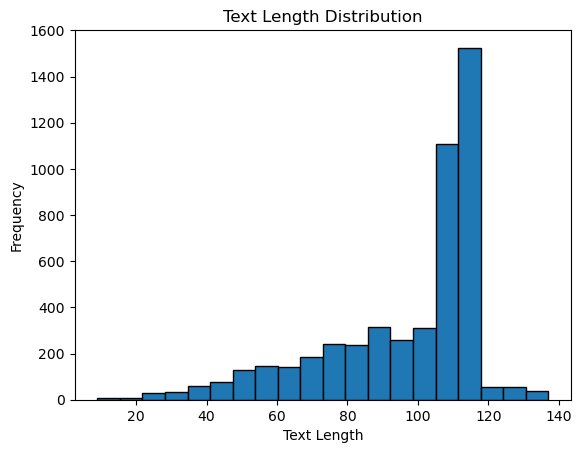

In [12]:
# Calculate text lengths and create a new column
df['Text_Length'] = df['Cleaned_Text'].apply(len)
# Create a histogram of text lengths
plt.hist(df['Text_Length'], bins=20, edgecolor='k')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

### Sentiment Analysis

In [17]:
# Define a function to get sentiment
def get_sentiment(text):
    analysis = TextBlob(text)
    # Determine the sentiment polarity (-1 to 1)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to your tweets and create a new column 'Sentiment'
df['Sentiment'] = df['Cleaned_Text'].apply(get_sentiment)

# Print the first few rows to check the results
df['Sentiment'].value_counts()


Sentiment
Neutral     1963
Positive    1550
Negative    1448
Name: count, dtype: int64

looks like most of the tweets range from 100 to 120 in length

In [67]:
df['Cleaned_Text'][0]

'this week baltimore 1 dead birmingham 4 injured nashville 7 injured west chester 4 dead uncc 2'

In [68]:
df['Created At']

0        Tue Apr 30 23:57:07 +0000 2019
1        Tue Apr 30 23:29:19 +0000 2019
2        Wed May 01 00:36:25 +0000 2019
3        Wed May 01 06:48:12 +0000 2019
4        Wed May 01 02:37:28 +0000 2019
                      ...              
12598    Fri Mar 29 20:32:42 +0000 2019
12599    Wed May 01 02:24:52 +0000 2019
12603    Wed May 01 05:28:42 +0000 2019
12605    Wed May 01 00:34:20 +0000 2019
12610    Wed May 01 05:44:51 +0000 2019
Name: Created At, Length: 4961, dtype: object

In [69]:
# Convert 'created_at' column to datetime
df['Created At'] = pd.to_datetime(df['Created At'], format='%a %b %d %H:%M:%S +0000 %Y')

# Sort DataFrame by the 'created_at' column
df_sorted = df.sort_values(by='Created At')

In [70]:
df_sorted["Created At"]

11129   2017-11-06 01:26:43
9613    2017-11-09 13:37:06
1438    2018-02-04 02:00:58
579     2018-02-15 03:55:39
10392   2018-02-18 21:41:38
                ...        
11571   2019-06-01 04:57:10
11575   2019-06-01 05:00:49
11579   2019-06-01 05:07:30
11596   2019-06-01 05:25:39
11612   2019-06-01 05:39:52
Name: Created At, Length: 4961, dtype: datetime64[ns]

In [71]:
# Split DataFrame into two based on the specified date (May 6th)
split_date = pd.to_datetime('2019-05-07')  # Adjust the date as needed
df1 = df_sorted[df_sorted['Created At'] <= split_date]
df2 = df_sorted[df_sorted['Created At'] > split_date]
# Reset the index for both DataFrames
df1.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

# Display or use the resulting DataFrames
print("DataFrame 1:")
print(df1)

print("\nDataFrame 2:")
print(df2)

DataFrame 1:
              Created At                                               Text   
0    2017-11-06 01:26:43  an interesting thing about living in America t...  \
1    2017-11-09 13:37:06  #ThursdayThoughts New #STEMDay learning opport...   
2    2018-02-04 02:00:58  I'm compiling databases of diverse STEM speake...   
3    2018-02-15 03:55:39  What is the fundamental commonality in all sch...   
4    2018-02-18 21:41:38  Over the next few hours I will post my recomme...   
...                  ...                                                ...   
1128 2019-05-06 21:24:12  Retaining women in STEM has important implicat...   
1129 2019-05-06 22:00:19  2019 I.O.W.A. STEM Teacher Award recipient @Ag...   
1130 2019-05-06 22:02:01  Hey Teachers!!  Thank you for all you do!  #Te...   
1131 2019-05-06 22:44:51  Is it time for high profile white women in STE...   
1132 2019-05-06 23:13:11  We had 7 of our STEM Engineering @ahstornadoes...   

                                      

#### The UCC Incident Occurred on April 30th thats the date with the most number of tweets regarding the incident and the most capable of giving us valuable information

In [72]:
# make a subset of data with only records with date 30 April
df_ucc = df_sorted[df_sorted['Created At'].dt.strftime('%Y-%m-%d')=="2019-04-30"]
df_ucc.tail()

,Created At,Text,Source,User Name,Location,Description,Followers Count,Quote Count,Reply Count,Retweet Count,Favorite Count,Cleaned_Text,Text_Length
478,2019-04-30 23:56:15,And as someone who works at UNC Charlotte and ...,"<a href=""http://twitter.com/#!/download/ipad"" ...",skullsinthestars,"Charlotte, NC","Professor of optical physics, blogger of physi...",14451,3,26.0,148.0,553.0,and as someone who works at unc charlotte and ...,114
0,2019-04-30 23:57:07,This week: \n• Baltimore: 1 dead\n• Birmingham...,"<a href=""http://twitter.com/download/iphone"" r...",Dante Vic,"Barcelona, Spain",rhythm & blues 🎶 #UNCC17,485,113,112.0,2441.0,4605.0,this week baltimore 1 dead birmingham 4 injure...,94
12081,2019-04-30 23:58:24,Listening to story now. A history Major who dr...,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",wallybeaver771,"Rock Hill, SC","I Support Trump to KAG, MAGA, Police, militar...",16887,0,0.0,1.0,0.0,listening to story now a history major who dro...,113
12094,2019-04-30 23:58:27,The Piece of Sh*t that just shot and killed pe...,"<a href=""http://twitter.com/download/iphone"" r...",✌🏽,"Charlotte, NC",HBCU Radio/TV Grad✊🏽🎓 Politics Geek🗳Pop Cultur...,1379,9,3.0,55.0,69.0,the piece of sh t that just shot and killed pe...,107
12097,2019-04-30 23:59:25,A reminder that only one party wants comprehen...,"<a href=""http://twitter.com/download/iphone"" r...",Lady Nono,The shoulder of Orion,🇨🇴 | Cat lover | Jazz fan | On a quest to find...,1899,0,2.0,1.0,3.0,a reminder that only one party wants comprehen...,105


we will only take the last 150 tweets since more than that will be more than our GPU capacity can handle

In [73]:
df_ucc_sub=df_ucc.tail(170)

In [74]:
# Concatenate all cleaned tweets into a single string variable
combined_tweets = ' '.join(df_ucc_sub['Cleaned_Text'])

# Print the combined tweets
print(combined_tweets)

via voxdotcom university of north carolina shooting what we know so far i am okay uncc prayers for everyone at uncc such a tragedy this is video from the uncc active shooter scene look very carefully at the police they aren t asking who or wh my heart goes out to uncc right now this is awful just in we just got this video of someone being dragged off uncc campus in handcuffs head down wcnc uncc two dead and four shot at unc charlotte on day of waka flacka flame concert 2 people were killed and 4 others were breaking on oann shooting at the university of north carolina in charlotte at least 2 dead 2 in very serious breaking video video appears to shows alleged unc charlotte shooter being taken away by police the shooter at uncc didn t say anything he just started shooting during our final presentations and we all ran ou imagine you sending your kids off to college and they don t come home for the summer this some bull shit uncc stoptheviolence my heart is broken i no longer feel safe at

In [75]:
len(combined_tweets)

15701

In [76]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A5000'

In [77]:
# Check the maximum token limit
max_token_limit = model.config.max_position_embeddings
print("Maximum Token Limit:", max_token_limit)

Maximum Token Limit: 4096


we have a maximun number of tokens for our model and exceeding this number will prompt aan error

In [78]:
#specify model path
model_name_or_path = "TheBloke/WizardLM-13B-V1.2-GPTQ"
#Define our model
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             torch_dtype=torch.float16,
                                             device_map="auto",
                                             revision="main")
#define Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


# UCC Incident Summarization

In [79]:
#the prompt will include the collected tweets to summarize
prompt = f"""A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. 
USER: write a report summarizing the following tweets,to extract information regarding the incident that happened and how people feel about it {combined_tweets}
Assistant: """


#create Input Ids
input_ids = tokenizer(prompt, return_tensors='pt').input_ids.cuda()


#building A Pipeline with hyperparameters for fine tuning
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=2000,
    temperature=0.5,
    top_p=0.95,
    repetition_penalty=1.15,
    max_length=2048
)

print(pipe(prompt)[0]['generated_text'])

Token indices sequence length is longer than the specified maximum sequence length for this model (3721 > 2048). Running this sequence through the model will result in indexing errors
/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1417: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `d

A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. 
USER: write a report summarizing the following tweets,to extract information regarding the incident that happened and how people feel about it via voxdotcom university of north carolina shooting what we know so far i am okay uncc prayers for everyone at uncc such a tragedy this is video from the uncc active shooter scene look very carefully at the police they aren t asking who or wh my heart goes out to uncc right now this is awful just in we just got this video of someone being dragged off uncc campus in handcuffs head down wcnc uncc two dead and four shot at unc charlotte on day of waka flacka flame concert 2 people were killed and 4 others were breaking on oann shooting at the university of north carolina in charlotte at least 2 dead 2 in very serious breaking video video appears to shows alleged unc charlotte shooter being taken

In [83]:
input_ids.shape[1]

3721

#### The STEM Incident Occurred on May 7th thats the date with the most number of tweets regarding the incident and the most capable of giving us valuable information

In [84]:
df_stem = df_sorted[df_sorted['Created At'].dt.strftime('%Y-%m-%d')=="2019-05-07"]
df_stem

,Created At,Text,Source,User Name,Location,Description,Followers Count,Quote Count,Reply Count,Retweet Count,Favorite Count,Cleaned_Text,Text_Length
1439,2019-05-07 00:12:22,Incredible #UNCC https://t.co/1trolteZAd,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Joe Bruno,"Charlotte, NC",Passionate reporter for @wsoctv covering gover...,17534,0,0.0,0.0,1.0,incredible uncc,15
1440,2019-05-07 00:13:48,Partner w/ #2019SACNAS to\n1️⃣Build brand awar...,"<a href=""http://twitter.com/download/iphone"" r...",SACNAS,"Santa Cruz, California",Advancing Chicanos/Hispanics & Native American...,11501,0,0.0,2.0,2.0,partner w 2019sacnas to 1 build brand awarenes...,102
1449,2019-05-07 00:22:48,"Riley Howell, the UNC Charlotte student killed...","<a href=""http://twitter.com/download/iphone"" r...",Emma Peel,Former democracy of N Carolina,"#Resistance #ClimateChange #ImpeachTrump💕dogs,...",14406,3,10.0,76.0,119.0,riley howell the unc charlotte student killed ...,112
1441,2019-05-07 00:34:07,Why not a student run #STEM show? It’s sooo ea...,"<a href=""http://twitter.com/download/iphone"" r...",John Kline🎭🎨🎬🎼💡,"Saratoga, California, USA",Director at WeVideo 4 Schools. All learners ex...,5130,0,1.0,2.0,5.0,why not a student run stem show it s sooo easy...,108
1442,2019-05-07 00:47:18,Prepping for our #STEMLIT engineering challeng...,"<a href=""http://twitter.com/download/iphone"" r...",𝙼𝚛𝚜. 𝙵𝚊𝚛𝚖𝚎𝚛’𝚜 𝙲𝚕𝚊𝚜𝚜,Madras Middle School,𝟾𝚝𝚑 𝙶𝚛𝚊𝚍𝚎 𝙴𝙻𝙰| @𝙼𝚊𝚍𝚛𝚊𝚜𝙵𝙶𝙴| #𝙲𝚘𝚠𝚎𝚝𝚊𝙴𝚍𝙲𝚑𝚊𝚝,1942,0,0.0,0.0,0.0,prepping for our stemlit engineering challenge...,109
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2090,2019-05-07 23:55:42,I would love to partner with community busines...,"<a href=""http://twitter.com/download/iphone"" r...",Juliann Doerschuk,NaN,PLTW teacher at Alliance Middle School,155,0,0.0,0.0,0.0,i would love to partner with community busines...,115
2113,2019-05-07 23:56:05,Eight students injured in school shooting in s...,"<a href=""http://twitter.com/download/iphone"" r...",Jake Tapper,NaN,CNN Anchor of @TheLeadCNN and @CNNSOTU and Chi...,2041366,3,21.0,24.0,38.0,eight students injured in school shooting in s...,86
2469,2019-05-07 23:56:05,During teacher appreciation week another schoo...,"<a href=""http://twitter.com/download/iphone"" r...",Keenon Clement,"Aurora, Co",Vista Peak Boys Basketball,433,4,4.0,48.0,165.0,during teacher appreciation week another schoo...,113
2095,2019-05-07 23:57:44,"😢💔 another school shooting in Colorado, \nDenv...","<a href=""http://twitter.com/#!/download/ipad"" ...",Limited Edition,Colorado USA,"LimitedEditionArt ❤️I Love God, Family and Cou...",637,0,0.0,0.0,0.0,another school shooting in colorado denver nat...,110


In [85]:
# Concatenate all cleaned tweets into a single string variable
combined_tweets = ' '.join(df_stem['Cleaned_Text'].tail(180))

# Print the combined tweets
print(combined_tweets)

b52malmet yes two shootings in colorado today highlands ranch and pueblo awaiting thoughts and prayers from dc repjasoncrow on the highlands ranch school shooting it is not enough to send thoughts and prayers it is empty at least seven injured in school shooting in suburban denver 2 suspects in custody follow just in at least 7 people have been injured in a colorado school shooting 2 suspects are in custody update at least 7 injured in colorado school shooting police say at least 7 people injured 2 suspects in custody after shooting at colorado stem school via hey 45 when the fuck are you going to stop all these school shootings asking for millions of kids you miserable bastard at least 7 students injured in denver school shootings stemschool and the reason america can t pass laws like au our hearts and thoughts are with the students teachers staff and families of stem school highlands ranch and all at least seven students were wounded in a denver area school shooting two suspects were

# STEM Incident Summarization

In [86]:
prompt = f"""A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. 
USER: write a report summarizing the following tweets,to extract information regarding the incident that happened and how people feel about it {combined_tweets}
Assistant: """


prompt_template=prompt
print(pipe(prompt_template)[0]['generated_text'])

/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:362: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:367: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Both `max_new_tokens` (=2000) and `max_length`(=2048) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions. 
USER: write a report summarizing the following tweets,to extract information regarding the incident that happened and how people feel about it b52malmet yes two shootings in colorado today highlands ranch and pueblo awaiting thoughts and prayers from dc repjasoncrow on the highlands ranch school shooting it is not enough to send thoughts and prayers it is empty at least seven injured in school shooting in suburban denver 2 suspects in custody follow just in at least 7 people have been injured in a colorado school shooting 2 suspects are in custody update at least 7 injured in colorado school shooting police say at least 7 people injured 2 suspects in custody after shooting at colorado stem school via hey 45 when the fuck are you going to stop all these school shootings asking for millions of kids you miserable bastard at least 7 stu

In [88]:
import pickle


In [93]:
import torch

#`model` is your trained model
model_filename = 'text_summarization_model.pth'
torch.save(model.state_dict(), model_filename)
